# Galilean Satellites - Initial State Estimation
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context


## Import Statements

In [1]:
# General imports
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# tudatpy imports
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.astro import time_conversion, element_conversion
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup

## Orbital Simulation

### Simulation Settings

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Define temporal scope of the simulation - equal to the time JUICE will spend in orbit around Jupiter
simulation_start_epoch = 31.0 * constants.JULIAN_YEAR + 182.0 * constants.JULIAN_DAY
simulation_end_epoch = 35.73 * constants.JULIAN_YEAR
simulation_duration = simulation_end_epoch - simulation_start_epoch

### Create the Environment

In [3]:
# Create default body settings for selected celestial bodies
jovian_moons_to_create = ['Io', 'Europa', 'Ganymede', 'Callisto']
planets_to_create = ['Jupiter', 'Saturn']
stars_to_create = ['Sun']
bodies_to_create = np.concatenate((jovian_moons_to_create, planets_to_create, stars_to_create))

# Create default body settings for bodies_to_create, with 'Jupiter'/'J2000'
# as global frame origin and orientation.
global_frame_origin = 'Jupiter'
global_frame_orientation = 'ECLIPJ2000'
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

### Ephemeris Settings Moons ###
# Get the original ephemeris settings
original_io_ephemeris_settings = body_settings.get('Io').ephemeris_settings
original_europa_ephemeris_settings = body_settings.get('Europa').ephemeris_settings
original_ganymede_ephemeris_settings = body_settings.get('Ganymede').ephemeris_settings
original_callisto_ephemeris_settings = body_settings.get('Callisto').ephemeris_settings
# Apply new tabulated ephemeris settings
body_settings.get('Io').ephemeris_settings = environment_setup.ephemeris.tabulated_from_existing(
    original_io_ephemeris_settings,
    simulation_start_epoch,
    simulation_end_epoch,
    time_step=5.0 * 60.0)
body_settings.get('Europa').ephemeris_settings = environment_setup.ephemeris.tabulated_from_existing(
    original_europa_ephemeris_settings,
    simulation_start_epoch,
    simulation_end_epoch,
    time_step=5.0 * 60.0)
body_settings.get('Ganymede').ephemeris_settings = environment_setup.ephemeris.tabulated_from_existing(
    original_ganymede_ephemeris_settings,
    simulation_start_epoch,
    simulation_end_epoch,
    time_step=5.0 * 60.0)
body_settings.get('Callisto').ephemeris_settings = environment_setup.ephemeris.tabulated_from_existing(
    original_callisto_ephemeris_settings,
    simulation_start_epoch,
    simulation_end_epoch,
    time_step=5.0 * 60.0)

### Rotational Models ###
# Define overall parameters describing the synchronous rotation model
central_body_name = "Jupiter"
original_frame = "ECLIPJ2000"
# Define satellite specific parameters and change rotation model settings
target_frame = 'IAU_IO'
body_settings.get('Io').rotation_model_settings = environment_setup.rotation_model.synchronous(
    central_body_name, original_frame, target_frame)
target_frame = 'IAU_Europa'
body_settings.get('Europa').rotation_model_settings = environment_setup.rotation_model.synchronous(
    central_body_name, original_frame, target_frame)
target_frame = 'IAU_Ganymede'
body_settings.get('Ganymede').rotation_model_settings = environment_setup.rotation_model.synchronous(
    central_body_name, original_frame, target_frame)
target_frame = 'IAU_Callisto'
body_settings.get('Callisto').rotation_model_settings = environment_setup.rotation_model.synchronous(
    central_body_name, original_frame, target_frame)

# Create system of selected bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create Propagator Settings

In [4]:
# Define bodies that are propagated, and their central bodies of propagation
bodies_to_propagate = ['Io', 'Europa', 'Ganymede', 'Callisto']
central_bodies = ['Jupiter', 'Jupiter', 'Jupiter', 'Jupiter']

### Acceleration Settings ###
# Dirkx et al. (2016) - restricted to second degree
love_number_moons = 0.3
dissipation_parameter_moons = 0.015
q_moons = love_number_moons / dissipation_parameter_moons
# Lari (2018)
mean_motion_io = 203.49 * (math.pi / 180) * 1 / constants.JULIAN_DAY
mean_motion_europa = 101.37 * (math.pi / 180) * 1 / constants.JULIAN_DAY
mean_motion_ganymede = 50.32 * (math.pi / 180) * 1 / constants.JULIAN_DAY
mean_motion_callisto = 21.57 * (math.pi / 180) * 1 / constants.JULIAN_DAY

# Dirkx et al. (2016) - restricted to second degree
love_number_jupiter = 0.38
dissipation_parameter_jupiter= 1.1E-5
q_jupiter = love_number_jupiter / dissipation_parameter_jupiter

# Lainey et al. (2009)
tidal_frequency_io = 23.3 # rad.day-1
spin_frequency_jupiter = math.pi/tidal_frequency_io + mean_motion_io

acceleration_settings_moons = dict()

### Io ###
time_lag_io = 1 / mean_motion_io * np.arctan(1 / q_moons)
time_lag_jupiter_io = 1/(spin_frequency_jupiter - mean_motion_io) * np.arctan(1 / q_jupiter)
acceleration_settings_io = dict(
    Jupiter=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(8, 0, 2, 2),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_moons,
                                                                                  time_lag_io,
                                                                                  True, False),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_jupiter,
                                                                                  time_lag_jupiter_io,
                                                                                  True, True),
             propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True)],
    Europa=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Ganymede=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Callisto=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Sun=[propagation_setup.acceleration.point_mass_gravity()],
    Saturn=[propagation_setup.acceleration.point_mass_gravity()]
)
acceleration_settings_moons['Io'] = acceleration_settings_io

### Europa ###
time_lag_europa = 1 / mean_motion_europa * np.arctan(1 / q_moons)
time_lag_jupiter_europa = 1 / (spin_frequency_jupiter - mean_motion_europa) * np.arctan(1 / q_jupiter)
acceleration_settings_europa = dict(
    Jupiter=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(8, 0, 2, 2),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_moons,
                                                                                  time_lag_europa,
                                                                                  True, False),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_jupiter,
                                                                                  time_lag_jupiter_europa,
                                                                                  True, True),
             propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True)],
    Io=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Ganymede=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Callisto=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Sun=[propagation_setup.acceleration.point_mass_gravity()],
    Saturn=[propagation_setup.acceleration.point_mass_gravity()]
)
acceleration_settings_moons['Europa'] = acceleration_settings_europa

### Ganymede ###
time_lag_ganymede = 1 / mean_motion_ganymede * np.arctan(1 / q_moons)
time_lag_jupiter_ganymede = 1 / (spin_frequency_jupiter - mean_motion_ganymede) * np.arctan(1 / q_jupiter)
acceleration_settings_ganymede = dict(
    Jupiter=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(8, 0, 2, 2),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_moons,
                                                                                  time_lag_ganymede,
                                                                                  True, False),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_jupiter,
                                                                                  time_lag_jupiter_ganymede,
                                                                                  True, True),
             propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True)],
    Io=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Europa=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Callisto=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Sun=[propagation_setup.acceleration.point_mass_gravity()],
    Saturn=[propagation_setup.acceleration.point_mass_gravity()]
)
acceleration_settings_moons['Ganymede'] = acceleration_settings_ganymede

### Callisto ###
time_lag_callisto = 1 / mean_motion_callisto * np.arctan(1 / q_moons)
time_lag_jupiter_callisto = 1 / (spin_frequency_jupiter - mean_motion_callisto) * np.arctan(1 / q_jupiter)
acceleration_settings_callisto = dict(
    Jupiter=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(8, 0, 2, 2),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_moons,
                                                                                  time_lag_callisto,
                                                                                  True, False),
             propagation_setup.acceleration.direct_tidal_dissipation_acceleration(love_number_jupiter,
                                                                                  time_lag_jupiter_callisto,
                                                                                  True, True),
             propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True)],
    Io=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Europa=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Ganymede=[propagation_setup.acceleration.mutual_spherical_harmonic_gravity(2, 2, 2, 2)],
    Sun=[propagation_setup.acceleration.point_mass_gravity()],
    Saturn=[propagation_setup.acceleration.point_mass_gravity()]
)
acceleration_settings_moons['Callisto'] = acceleration_settings_callisto

acceleration_settings = acceleration_settings_moons
# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies)

# Define initial state
initial_states = list()
for body in bodies_to_propagate:
    initial_states.append(spice.get_body_cartesian_state_at_epoch(
        target_body_name=body,
        observer_body_name='Jupiter',
        reference_frame_name='ECLIPJ2000',
        aberration_corrections='none',
        ephemeris_time=simulation_start_epoch))
initial_states = np.concatenate(initial_states)

### Integrator Settings ###
# Use fixed step-size integrator (DP8) with fixed time-step of 30 minutes
# Create integrator settings
time_step_sec = 30.0 * 60.0
integrator_settings = propagation_setup.integrator. \
    runge_kutta_fixed_step_size(initial_time_step=time_step_sec,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

### Termination Settings ###
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Define Keplerian elements of the Galilean moons as dependent variables
dependent_variables_to_save = [propagation_setup.dependent_variable.keplerian_state('Io', 'Jupiter'),
                               propagation_setup.dependent_variable.keplerian_state('Europa', 'Jupiter'),
                               propagation_setup.dependent_variable.keplerian_state('Ganymede', 'Jupiter'),
                               propagation_setup.dependent_variable.keplerian_state('Callisto', 'Jupiter')]

### Propagator Settings ###
propagator_settings = propagation_setup.propagator. \
    translational(central_bodies=central_bodies,
                  acceleration_models=acceleration_models,
                  bodies_to_integrate=bodies_to_propagate,
                  initial_states=initial_states,
                  initial_time=simulation_start_epoch,
                  integrator_settings=integrator_settings,
                  termination_settings=termination_condition,
                  output_variables=dependent_variables_to_save)

## Orbital Estimation

## Create Link Ends for the Moons

In [5]:
link_ends_io = dict()
link_ends_io[estimation_setup.observation.observed_body] = estimation_setup.observation.\
    body_origin_link_end_id('Io')
link_definition_io = estimation_setup.observation.LinkDefinition(link_ends_io)

link_ends_europa = dict()
link_ends_europa[estimation_setup.observation.observed_body] = estimation_setup.observation.\
    body_origin_link_end_id('Europa')
link_definition_europa = estimation_setup.observation.LinkDefinition(link_ends_europa)

link_ends_ganymede = dict()
link_ends_ganymede[estimation_setup.observation.observed_body] = estimation_setup.observation.\
    body_origin_link_end_id('Ganymede')
link_definition_ganymede = estimation_setup.observation.LinkDefinition(link_ends_ganymede)

link_ends_callisto = dict()
link_ends_callisto[estimation_setup.observation.observed_body] = estimation_setup.observation.\
    body_origin_link_end_id('Callisto')
link_definition_callisto = estimation_setup.observation.LinkDefinition(link_ends_callisto)

### Observation Model Settings

In [6]:
position_observation_settings = [estimation_setup.observation.cartesian_position(link_definition_io),
                                 estimation_setup.observation.cartesian_position(link_definition_europa),
                                 estimation_setup.observation.cartesian_position(link_definition_ganymede),
                                 estimation_setup.observation.cartesian_position(link_definition_callisto)]

### Observation Simulation Settings

In [7]:
# Define epochs at which the ephemerides shall be checked
observation_times = np.arange(simulation_start_epoch, simulation_end_epoch, 3.0 * 3600)
# Create the observation simulation settings per moon
observation_simulation_settings_io = estimation_setup.observation.tabulated_simulation_settings(
    estimation_setup.observation.position_observable_type,
    link_definition_io,
    observation_times,
    reference_link_end_type=estimation_setup.observation.observed_body)
observation_simulation_settings_europa = estimation_setup.observation.tabulated_simulation_settings(
    estimation_setup.observation.position_observable_type,
    link_definition_europa,
    observation_times,
    reference_link_end_type=estimation_setup.observation.observed_body)
observation_simulation_settings_ganymede = estimation_setup.observation.tabulated_simulation_settings(
    estimation_setup.observation.position_observable_type,
    link_definition_ganymede,
    observation_times,
    reference_link_end_type=estimation_setup.observation.observed_body)
observation_simulation_settings_callisto = estimation_setup.observation.tabulated_simulation_settings(
    estimation_setup.observation.position_observable_type,
    link_definition_callisto,
    observation_times,
    reference_link_end_type=estimation_setup.observation.observed_body)
# Create conclusive list of observation simulation settings
observation_simulation_settings = [observation_simulation_settings_io,
                                   observation_simulation_settings_europa,
                                   observation_simulation_settings_ganymede,
                                   observation_simulation_settings_callisto]

### Simulate Ephemeris' States of Satellites

In [8]:
# Create observation simulators
ephemeris_observation_simulators = estimation_setup.create_observation_simulators(
    position_observation_settings, bodies)
# Get ephemeris states as ObservationCollection
print('Checking ephemerides...')
ephemeris_satellite_states = estimation.simulate_observations(
    observation_simulation_settings,
    ephemeris_observation_simulators,
    bodies)

Checking ephemerides...


### Define Estimable Parameters

In [9]:
parameters_to_estimate_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)
parameters_to_estimate = estimation_setup.create_parameter_set(parameters_to_estimate_settings, bodies)
original_parameter_vector = parameters_to_estimate.parameter_vector

### Perform the Estimation

In [10]:
print('Running propagation...')
estimator = numerical_simulation.Estimator(bodies, parameters_to_estimate,
                                           position_observation_settings, propagator_settings)

Running propagation...


Warning, time-derivative of synchronous rotation matrix not yet implemented (using zero matrix)
Warning, time-derivative of synchronous rotation matrix not yet implemented (using zero matrix)
Warning, time-derivative of synchronous rotation matrix not yet implemented (using zero matrix)
Warning, time-derivative of synchronous rotation matrix not yet implemented (using zero matrix)


In [11]:
# Create input object for the estimation
estimation_input = estimation.EstimationInput(ephemeris_satellite_states)
# Set methodological options
estimation_input.define_estimation_settings(save_state_history_per_iteration=True)
# Perform the estimation
print('Performing the estimation...')
print(f'Original initial states: {original_parameter_vector}')

Performing the estimation...
Original initial states: [ 3.75198710e+08  1.95541522e+08  1.23057063e+07 -8.02166409e+03
  1.52936011e+04  4.18829914e+02 -1.70296358e+08  6.50642159e+08
  1.61093438e+07 -1.32919139e+04 -3.34039879e+03 -2.65746870e+02
 -6.68065646e+08 -8.35897837e+08 -4.21778904e+07  8.50535380e+03
 -6.77457213e+03 -1.25723648e+02 -1.66091018e+09 -9.12947469e+08
 -5.06117658e+07  3.94139992e+03 -7.12753850e+03 -1.68779927e+02]


In [12]:
estimation_output = estimator.perform_estimation(estimation_input)
initial_states_updated = parameters_to_estimate.parameter_vector
print('Done with the estimation...')
print(f'Updated initial states: {initial_states_updated}')

Calculating residuals and partials 148392
Done with the estimation...
Updated initial states: [ 3.75203978e+08  1.95543057e+08  1.23090359e+07 -8.02168352e+03
  1.52936274e+04  4.18687047e+02 -1.70303307e+08  6.50645871e+08
  1.61058310e+07 -1.32919844e+04 -3.34048377e+03 -2.65756787e+02
 -6.68064694e+08 -8.35905970e+08 -4.21769821e+07  8.50544945e+03
 -6.77462084e+03 -1.25724041e+02 -1.66092270e+09 -9.12954580e+08
 -5.06121462e+07  3.94143123e+03 -7.12759590e+03 -1.68779682e+02]


Warning when performing least squares, condition number is 2.9625e+09


Parameter update      105484      -191342     -1749.66      7.80967      4.14196     0.148574     -15430.9      295.776     -3865.37    -0.065405    -0.191541   -0.0252763     -16808.9      5755.87       1175.9   -0.0570734    -0.237448  -0.00818436     -14560.2     -3982.31     -314.641    0.0187615   -0.0629676 -8.34077e-05
Current residual: 2.55088e+07
Calculating residuals and partials 148392
Parameter update    -100165      192899     5081.07    -7.83004    -4.11348   -0.291443     8471.96     3413.42      352.22 -0.00504987    0.106395   0.0153705     17759.3    -13886.7    -267.624    0.152719    0.188716  0.00779019     2036.17    -3128.35    -65.7271   0.0125565  0.00556689 0.000328891
Current residual: 210129
Calculating residuals and partials 148392
Parameter update     -50.238      -21.993     0.474185  0.000951119  -0.00211046  -0.00016181      5.87695      1.22198    -0.261103 -2.87166e-05  9.44147e-05  1.12065e-05     0.354935    -0.660502  -0.00259194 -5.75614e-07  1.22

Warning when performing least squares, condition number is 2.95465e+09
Warning when performing least squares, condition number is 2.95881e+09
Warning when performing least squares, condition number is 2.95893e+09
Warning when performing least squares, condition number is 2.95893e+09


## Post-Processing

In [13]:
def calculate_mean_longitude(kepler_elements: dict):
    # Calculate dictionary for moon-wise longitudes
    mean_longitude_dict = dict()
    # Loop over every moon of interest (Io, Europa, Ganymede)
    for moon in kepler_elements.keys():
        mean_anomaly_per_moon = list()
        kepler_elements_per_moon = kepler_elements[moon]
        # For every epoch get the mean anomaly of the moon
        for i in range(len(kepler_elements[moon])):
            mean_anomaly_per_moon.append(element_conversion.true_to_mean_anomaly(
                eccentricity=kepler_elements_per_moon[i, 1],
                true_anomaly=kepler_elements_per_moon[i, 5]))
        mean_anomaly_per_moon = np.array(mean_anomaly_per_moon)
        mean_anomaly_per_moon[mean_anomaly_per_moon < 0] = mean_anomaly_per_moon[mean_anomaly_per_moon < 0] \
                                                           + 2 * math.pi
        # Calculate the mean longitude as
        # (longitude of the ascending node) + (argument of the pericenter) + (mean anomaly)
        longitude_of_the_ascending_node = kepler_elements_per_moon[:, 4]
        argument_of_the_pericenter = kepler_elements_per_moon[:, 3]

        mean_longitude_per_moon = longitude_of_the_ascending_node + argument_of_the_pericenter + mean_anomaly_per_moon
        # Include epoch-wise mean longitude in dictionary
        mean_longitude_per_moon = np.mod(mean_longitude_per_moon, 2*math.pi)
        mean_longitude_dict[moon] = mean_longitude_per_moon

    return mean_longitude_dict

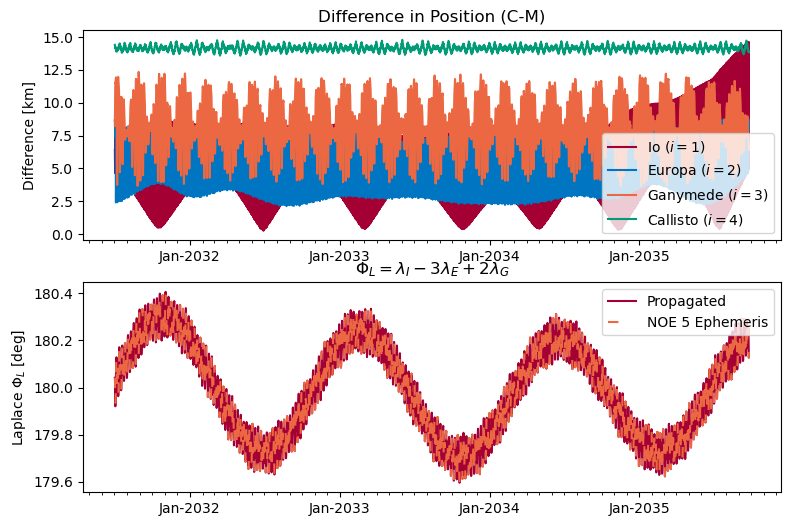

In [14]:
### LOAD DATA ###
simulator_object = estimation_output.simulation_results_per_iteration[-1]
state_history = simulator_object.dynamics_results.state_history
dependent_variable_history = simulator_object.dynamics_results.dependent_variable_history

### Ephemeris Kepler elements ####
# Initialize containers
ephemeris_state_history = dict()
ephemeris_keplerian_states = dict()
jupiter_gravitational_parameter = bodies.get('Jupiter').gravitational_parameter
# Loop over the propagated states and use the IMCEE ephemeris as benchmark solution
for epoch in state_history.keys():
    io_from_ephemeris = spice.get_body_cartesian_state_at_epoch(
        target_body_name='Io',
        observer_body_name='Jupiter',
        reference_frame_name='ECLIPJ2000',
        aberration_corrections='none',
        ephemeris_time=epoch)
    keplerian_state_io = element_conversion.cartesian_to_keplerian(io_from_ephemeris,
                                                                   jupiter_gravitational_parameter)

    europa_from_ephemeris = spice.get_body_cartesian_state_at_epoch(
        target_body_name='Europa',
        observer_body_name='Jupiter',
        reference_frame_name='ECLIPJ2000',
        aberration_corrections='none',
        ephemeris_time=epoch)
    keplerian_state_europa = element_conversion.cartesian_to_keplerian(europa_from_ephemeris,
                                                                       jupiter_gravitational_parameter)

    ganymede_from_ephemeris = spice.get_body_cartesian_state_at_epoch(
        target_body_name='Ganymede',
        observer_body_name='Jupiter',
        reference_frame_name='ECLIPJ2000',
        aberration_corrections='none',
        ephemeris_time=epoch)
    keplerian_state_ganymede = element_conversion.cartesian_to_keplerian(ganymede_from_ephemeris,
                                                                         jupiter_gravitational_parameter)

    callisto_from_ephemeris = spice.get_body_cartesian_state_at_epoch(
        target_body_name='Callisto',
        observer_body_name='Jupiter',
        reference_frame_name='ECLIPJ2000',
        aberration_corrections='none',
        ephemeris_time=epoch)
    keplerian_state_callisto = element_conversion.cartesian_to_keplerian(callisto_from_ephemeris,
                                                                         jupiter_gravitational_parameter)

    ephemeris_state = np.concatenate((io_from_ephemeris, europa_from_ephemeris,
                                      ganymede_from_ephemeris, callisto_from_ephemeris))
    keplerian_state = np.concatenate((keplerian_state_io, keplerian_state_europa,
                                      keplerian_state_ganymede, keplerian_state_callisto))

    ephemeris_state_history[epoch] = ephemeris_state
    ephemeris_keplerian_states[epoch] = keplerian_state

propagation_kepler_elements = np.vstack(list(dependent_variable_history.values()))
ephemeris_kepler_elements = np.vstack(list(ephemeris_keplerian_states.values()))

propagated_kepler_elements_dict = {'Io': propagation_kepler_elements[:, 0:6],
                                   'Europa': propagation_kepler_elements[:, 6:12],
                                   'Ganymede': propagation_kepler_elements[:, 12:18],
                                   'Callisto': propagation_kepler_elements[:, 18:24]}
ephemeris_kepler_elements_dict = {'Io': ephemeris_kepler_elements[:, 0:6],
                                  'Europa': ephemeris_kepler_elements[:, 6:12],
                                  'Ganymede': ephemeris_kepler_elements[:, 12:18],
                                  'Callisto': ephemeris_kepler_elements[:, 18:24]}

state_history_difference = np.vstack(list(state_history.values())) - np.vstack(list(ephemeris_state_history.values()))
position_difference = {'Io': state_history_difference[:, 0:3],
                       'Europa': state_history_difference[:, 6:9],
                       'Ganymede': state_history_difference[:, 12:15],
                       'Callisto': state_history_difference[:, 18:21]}

# Calculate propagated Laplace stability

mean_longitude_dict_prop = calculate_mean_longitude(propagated_kepler_elements_dict)

laplace_stability_prop = mean_longitude_dict_prop['Io'] \
                         - 3 * mean_longitude_dict_prop['Europa'] \
                         + 2 * mean_longitude_dict_prop['Ganymede']
laplace_stability_prop = np.mod(laplace_stability_prop, 2 * math.pi)

# Calculate ephemeris Laplace stability

mean_longitude_dict_ephem = calculate_mean_longitude(ephemeris_kepler_elements_dict)

laplace_stability_ephem = mean_longitude_dict_ephem['Io'] \
                         - 3 * mean_longitude_dict_ephem['Europa'] \
                         + 2 * mean_longitude_dict_ephem['Ganymede']
laplace_stability_ephem = np.mod(laplace_stability_ephem, 2 * math.pi)

### PLOTTING ###
time2plt = list()
epochs_julian_seconds = np.vstack(list(state_history.keys()))
for epoch in epochs_julian_seconds:
    epoch_days = constants.JULIAN_DAY_ON_J2000 + epoch / constants.JULIAN_DAY
    time2plt.append(time_conversion.julian_day_to_calendar_date(epoch_days))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))

ax1.plot(time2plt, np.linalg.norm(position_difference['Io'], axis=1) * 1E-3,
         label=r'Io ($i=1$)', c='#A50034')
ax1.plot(time2plt, np.linalg.norm(position_difference['Europa'], axis=1) * 1E-3,
         label=r'Europa ($i=2$)', c='#0076C2')
ax1.plot(time2plt, np.linalg.norm(position_difference['Ganymede'], axis=1) * 1E-3,
         label=r'Ganymede ($i=3$)', c='#EC6842')
ax1.plot(time2plt, np.linalg.norm(position_difference['Callisto'], axis=1) * 1E-3,
         label=r'Callisto ($i=4$)', c='#009B77')
ax1.set_title(r'Difference in Position (C-M)')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax1.set_ylabel(r'Difference [km]')
ax1.legend()

ax2.plot(time2plt, laplace_stability_prop * 180 / math.pi, label='Propagated', c='#A50034')
ax2.plot(time2plt, laplace_stability_ephem * 180 / math.pi, label='NOE 5 Ephemeris', c='#EC6842',
         linestyle=(0, (5, 10)))
ax2.set_title(r'$\Phi_L=\lambda_I-3 \lambda_E+2 \lambda_G$')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax2.set_ylabel(r'Laplace $\Phi_L$ [deg]')
ax2.legend();